/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


<Quantity 277.69230769 mm>

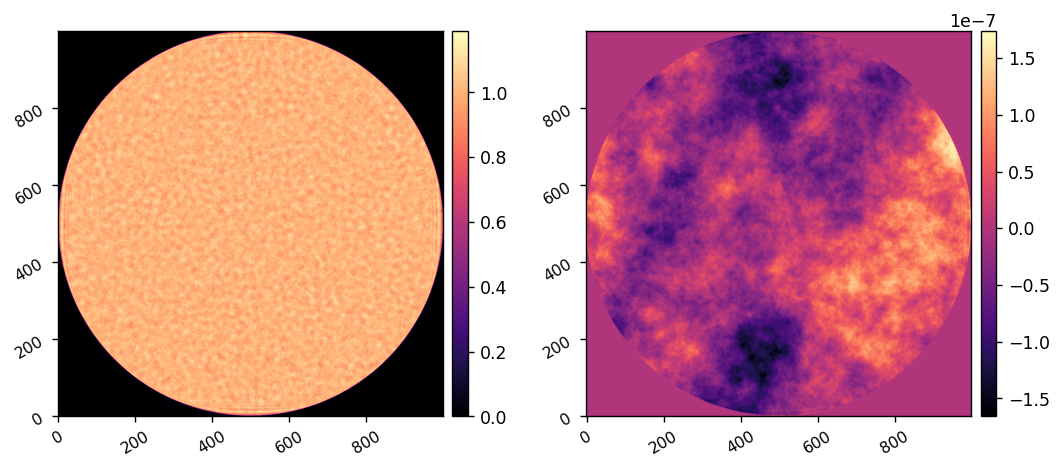

In [4]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fresnel_coro_1 as fresnel
from apra_pop_models import fresnel_ote
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
import apra_pop_models.props as props
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
from apra_pop_models.imshows import *

model = fresnel.CORO()

FN = 500
optimal_dm1_dm2 = (model.pupil_diam**2/(model.wavelength_c*FN)).to(u.mm)
display(optimal_dm1_dm2)

ote_pupil = fits.getdata('../wfe-data/telescope_wfe.fits')
imshow2(ote_pupil[0], ote_pupil[1])


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Propagating wavelength 650.000 nm.


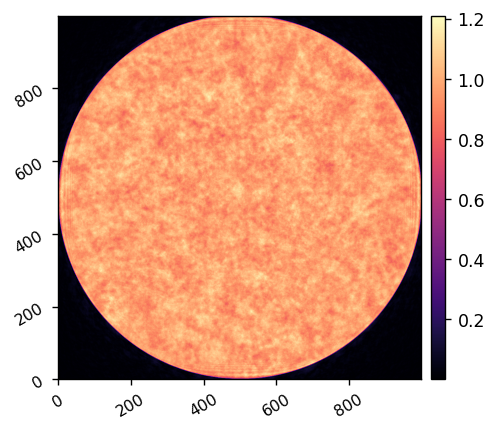

1000


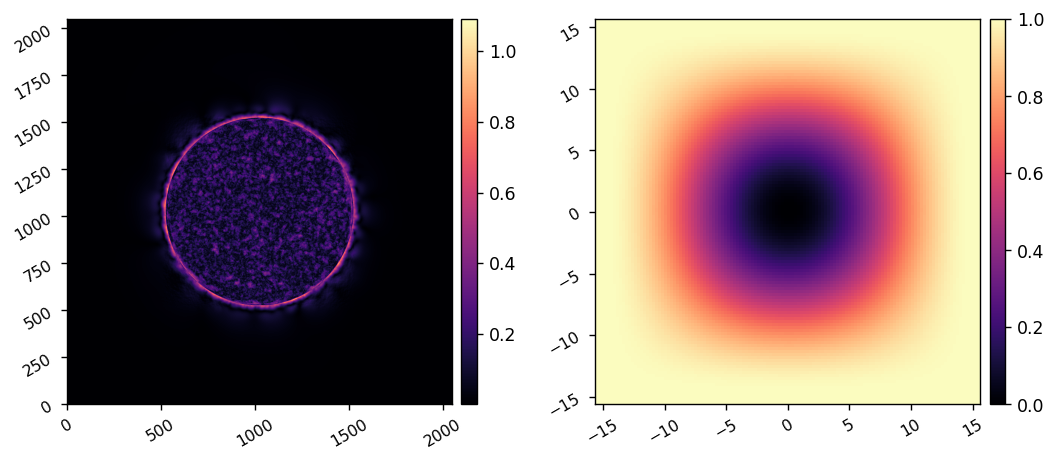

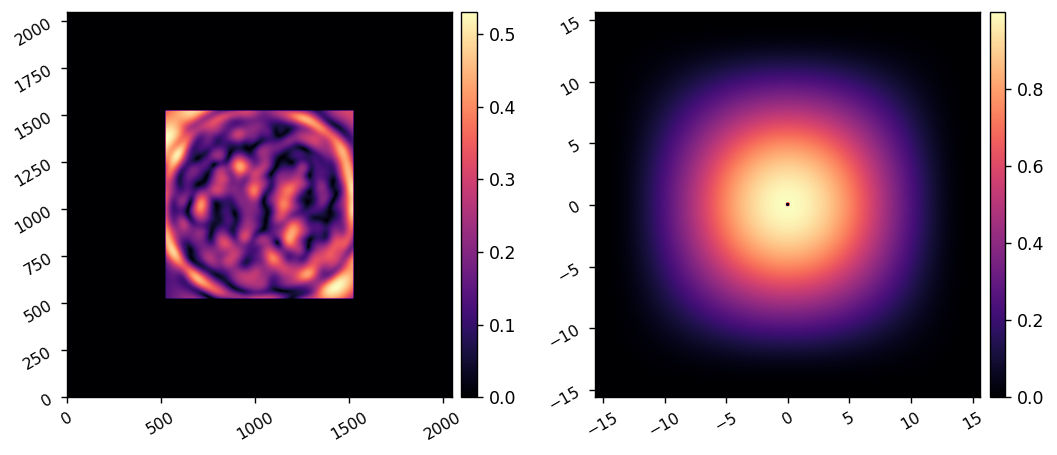

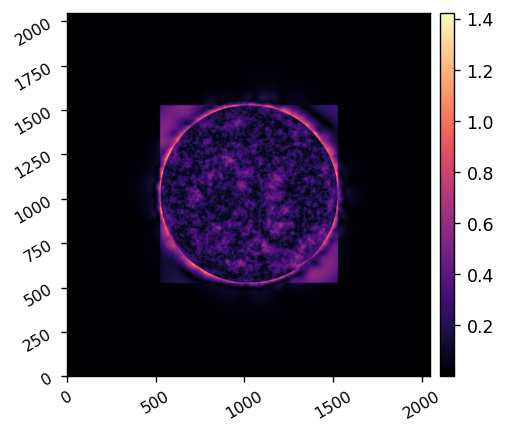

OutOfMemoryError: Out of memory allocating 67,108,864 bytes (allocated so far: 9,209,968,128 bytes).

In [6]:
reload(fresnel)
reload(apra_pop_models.props)
model = fresnel.CORO()
model.npsf = 200
model.WFE.amplitude = ote_pupil[0]
model.WFE.opd = ote_pupil[1]
model.use_opds = True

model.Imax_ref = xp.max(model.snap())

pup_ratio = model.pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio/0.9
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-8
separation = 3
comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# model.set_dm1(ensure_np_array(comm1))
# model.set_dm2(ensure_np_array(comm2))

model.use_fpm = True

wfs = model.calc_wfs()
im = wfs[-1].intensity
print(xp.max(im))
imshow2(im, wfs[-1].phase, lognorm1=True, vmin1=xp.max(im)/1e5, cmap2='twilight', 
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'), 
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 5.22, fill=False, color='lime'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 10.22, fill=False, color='red')])


In [1]:
!nvidia-smi

Tue May 28 14:44:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   35C    P0             62W /  300W |   71815MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
0.025*1200

30.0

In [4]:
model.N

2048

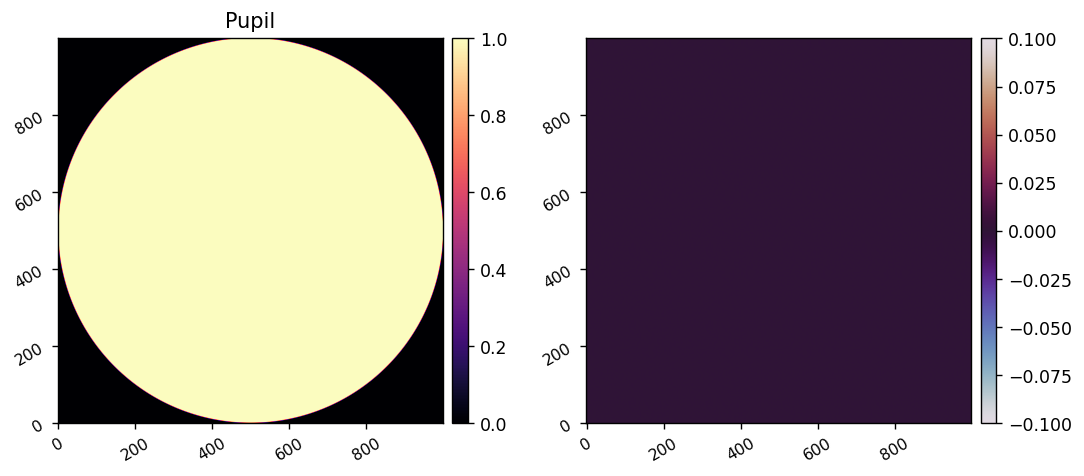

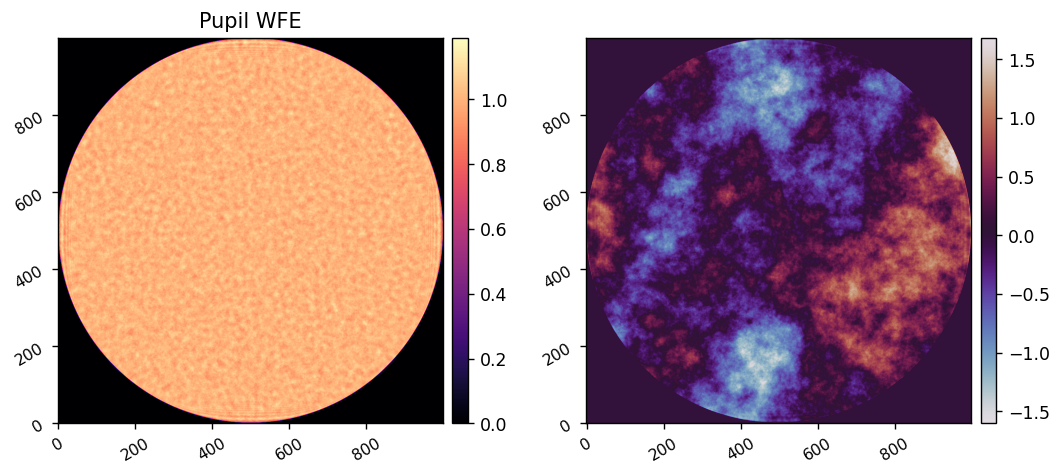

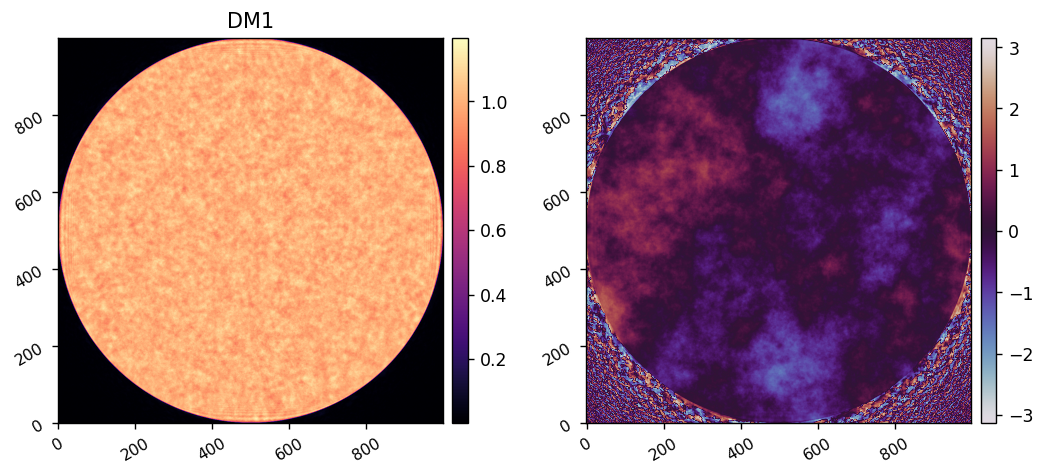

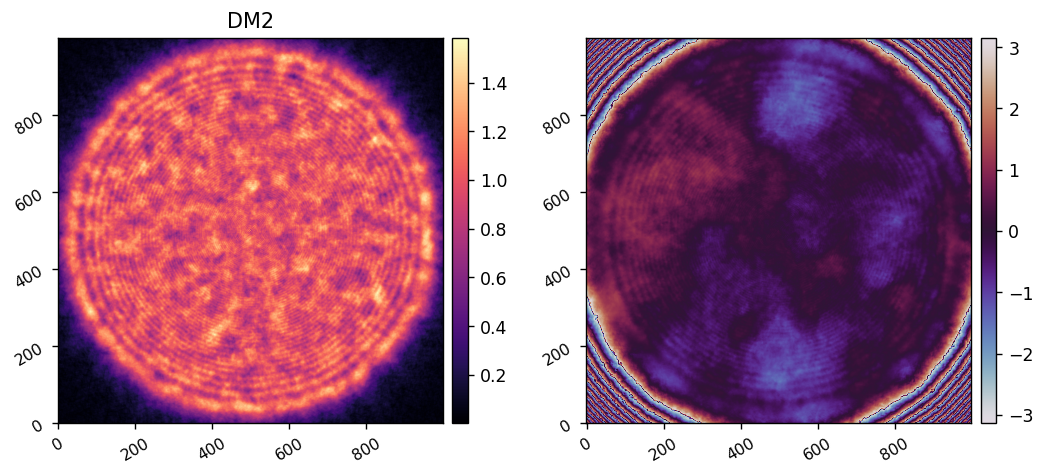

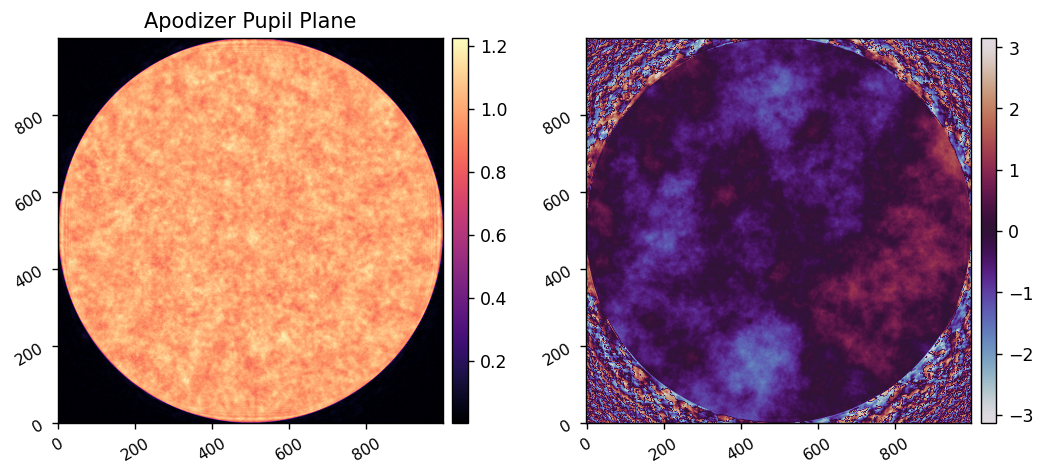

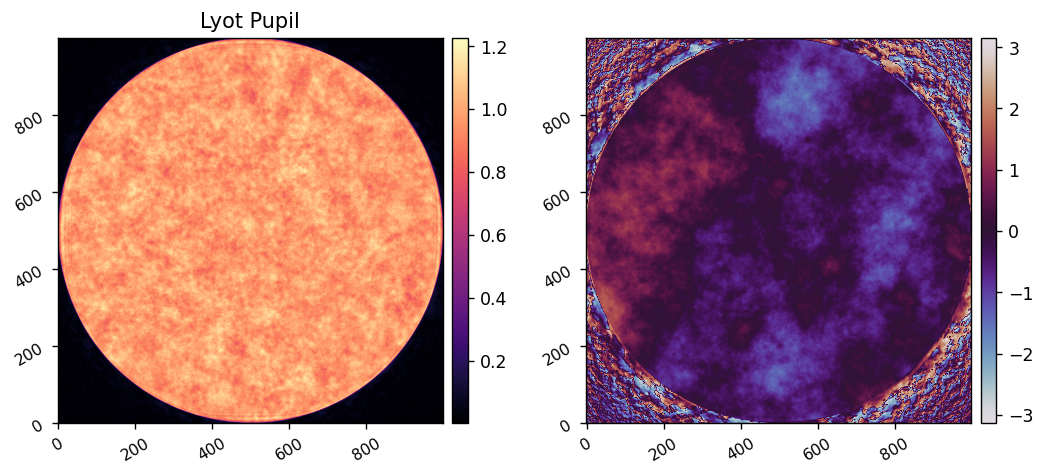

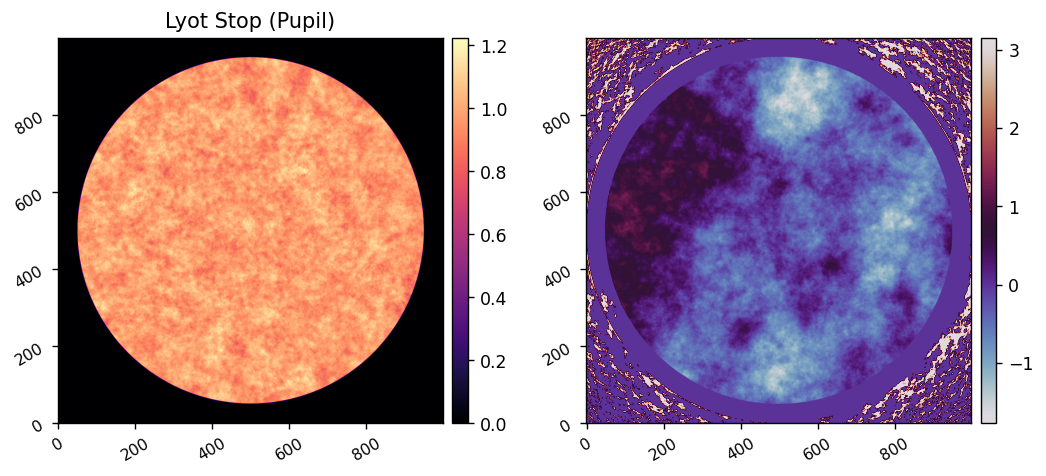

In [75]:
for i,wf in enumerate(wfs):
    if 'Pupil' in wf.location or 'DM' in wf.location:
        imshow2(wf.amplitude, wf.phase, wf.location[6:], npix=model.npix,
                cmap1='magma', cmap2='twilight')

In [92]:
reload(fresnel)
reload(apra_pop_models.props)
model = fresnel.CORO()
model.WFE.amplitude = ote_amp
model.WFE.opd = ote_opd
model.use_opds = True

model.return_lyot = True

lyot_amp, lyot_opd = model.calc_wf()

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


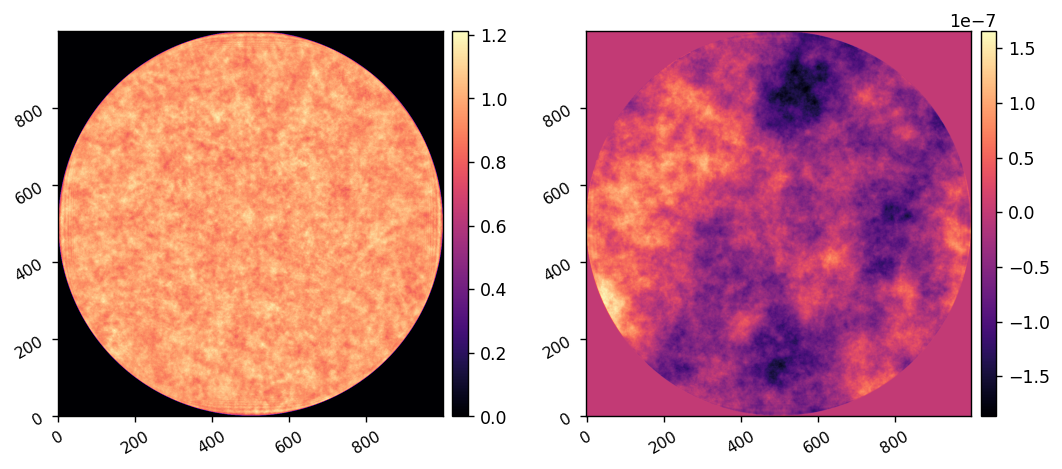

In [93]:
imshow2(lyot_amp, lyot_opd)

In [96]:
coro_data = xp.array([lyot_amp, lyot_opd])
utils.save_fits('../wfe-data/coro_wfe.fits', coro_data)

Saved data to:  ../wfe-data/coro_wfe.fits


In [ ]:
rms_amp = xp.sqrt(xp.mean(xp.square(coro_pupil[0][model.APMASK]-xp.mean(coro_pupil[0][model.APMASK]))))
rms_opd = xp.sqrt(xp.mean(xp.square(coro_pupil[1][model.APMASK])))


0.9702302396966975


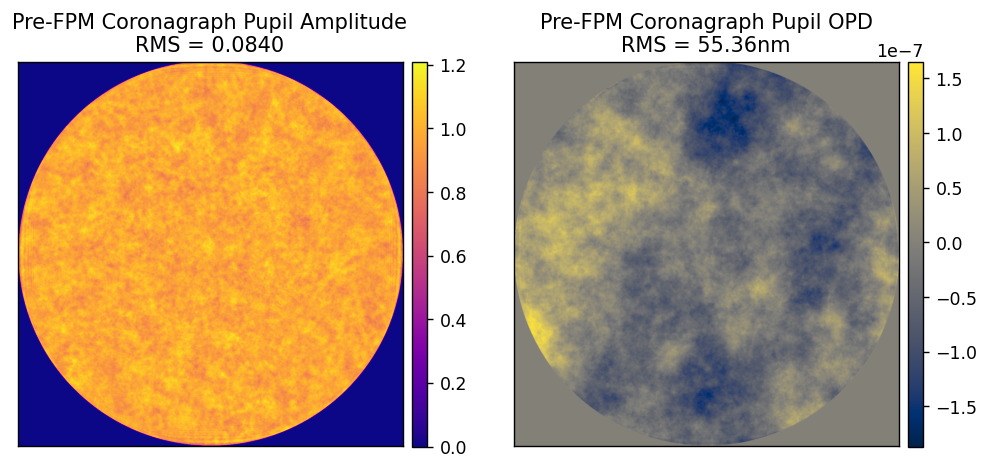

In [105]:
mean_amp = xp.mean(coro_data[0][model.APMASK])
print(mean_amp)
rms_amp = xp.sqrt(xp.mean(xp.square(coro_data[0][model.APMASK]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(coro_data[1][model.APMASK]))) * 1e9

fig, ax = imshow2(coro_data[0], coro_data[1], 
                  f'Pre-FPM Coronagraph Pupil Amplitude\nRMS = {rms_amp:.4f}', 
                  f'Pre-FPM Coronagraph Pupil OPD\nRMS = {rms_opd:.2f}nm', 
                  cmap1='plasma', cmap2='cividis', 
                  wspace=0.05,
                  return_fig=True, display_fig=False)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
display(fig)